In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.io import loadmat
import random
import pandas as pd

import ERS_functions as ERS

In [3]:
#!!!! Read note in docstring below about re-RUNNING This script !!!!

# Defining parameters

student_number = 5381827
student_number = list(str(student_number))
for i in range(len(student_number)):
    student_number[i] = int(student_number[i])
A, B, C, D, E, F, G = student_number


#g = 9.81                    # Gravitational acceleration [m/s^2]
xi = 0.040 + C * 1e-3        # Damping ratio []
a_g_r = (0.33 + D * 1e-2)    # Peak ground acceleration [g]
gamma = 1.4                  # Importance factor [] - Importance class IV (assigned) corresponds to gamma=1.4 according to EN1998-1-1 (par 4.2.5)
a_g_ref = a_g_r*gamma        # Horizontal Reference Acceleration (EN1998-1)
a_vg_ref = a_g_ref*0.45      # Vertical Reference Acceleration (EN1998-1) - Type 2 Earthquake (M_s = 5.0, assigned parameter)

# Note: Input accelerations are in [g], the following block converts the signal to [m/s^2] and then saves it to the Signal xlsx files. 
#       All functions from the ERS module are documented to run in [g] units, but data is read from xlsx signal files, therefore we input accelerations in [m/s] and output spectra in [m/s] (i.e. no difference for the operation of functions)

In [ ]:
'''
(c) TU Delft
This script will analyse all the accelerograms (x,y,z) direction and
construct their ERS based on a numerical calculation. The mean of the
horizontal and vertical acting accelerograms will be calculated as well
and will be saved to a .mat file. Furthermore, the signals will be
made RFEM ready and placed in a folder. 

!!!!!!!!!!!!!!!!!!!!!!
Please note that every time
this file runs, it will add the signal data to the existing files in
"Signals", therefore make sure that if you re-run this file you
delete those files.

At some locations you will find '<---- fill in equation', please fill in the
appropriate equation here to continue.
'''

# generate the random number to choose specific files
files = random.sample(range(8),5)
print('Chosen files are: ' + str(files))

## importing acclerograms and looping over them to create the ERS

# Determine scaling value:
gamma = gamma                           # (defined in parameter section) <------ fill in equation here
PGA = a_g_r*gamma                       # (defined in parameter section) <------ fill in equation here


# initialising loop
N = len(files)
SA_el_hor = np.zeros((201,2*N))
SA_el_ver = np.zeros((201,N))
ag_all = [None] * (3*N)
NPTS_all = np.zeros((N,))
Dt_all = np.zeros((N,))

## loops for reading files and decomposing in principal directions
jj = 0
for ifile in files:
    NPTS, Dt, ag_time = ERS.fnc_read_induced_signals(ifile)
    for ii in range(3):
        ag_all[3*jj+ii] = ag_time[ii]
    NPTS_all[jj] = NPTS
    Dt_all[jj] = Dt
    jj += 1
    
for iN in range(N):
    # get the file locations
    hor1 = 3*iN + 1 
    hor2 = 3*iN + 2
    ver = 3*iN + 3

    ag_1, ag_2 = ERS.fnc_calc_covariance(ag_all[hor1-1], ag_all[hor2-1], ag_all[ver-1], Dt_all[iN])
    ag_all[hor1-1] = ag_1 # store 1st principal hor. dir.
    ag_all[hor2-1] = ag_2 # store 2nd principal hor. dir.    

    
# loop for calculation response spectra and saving decomposed signals such that ZeusNL is able to use them

PGA_init = [None] * (3*N) 

for iN in range(1, N+1):
    # get the file locations
    hor1 = 3*(iN-1) + 0  
    hor2 = 3*(iN-1) + 1
    ver = 3*(iN-1) + 2
    for ifile in [hor1, hor2, ver]:
        # read the signal
        ag_time = ag_all[ifile]
        NPTS = NPTS_all[iN-1]
        Dt = Dt_all[iN-1]
        
        # In order to scale down the time history signal to a predefined PGA we 
        # have to:
        #   1) Find the initial PGA (absolute value) of the signal named after 
        #      "PGA_init" below; 
        #   2) We scale the signal such that PGA = PGA_max in case of the first and second principal hor. dir. 
        #      and the vertical one is scaled with the same ratio as the first principal hor. dir.
                
        PGA_init[ifile] = np.max(np.abs(ag_time))/(100*9.81)    #  (data is in cm/s^2) - convert to g
        
        if ifile != ver: 
            ag_time = PGA/PGA_init[ifile] * ag_time / (100*9.81) 
        else:
            ag_time = PGA/PGA_init[hor1] * ag_time / (100*9.81)  
        
        ## calculate the elastic response spectrum
        xi = xi                            # (defined in parameter section) <------ fill in equation here
        
        SA_el, Fel  =  ERS.fnc_Elastic_Response_Spectrum(ag_time, Dt, NPTS, xi)

        # determine in which array it should be stored
        if ifile == hor1:
            loc = 2*(iN-1) + 1
            name = 'hor1'
            SA_el_hor[:, loc-1] = SA_el
            ag_hor1 = ag_time * 9.81 # convert back to m/s2 for RFEM
        elif ifile == hor2:
            loc = 2*(iN-1) + 2
            name = 'hor2'
            SA_el_hor[:, loc-1] = SA_el
            ag_hor2 = ag_time * 9.81 # convert back to m/s2 for RFEM
        elif ifile == ver:
            loc = (iN-1) + 1
            name = 'ver'
            SA_el_ver[:, loc-1] = SA_el
            ag_vert = ag_time * 9.81 # convert back to m/s2 for RFEM
        
        ## Use the earthquake signal data to generate signals for ZeusNL for question 4
        t = np.linspace(0, len(ag_time)*Dt, len(ag_time))  # create time vector
        signal = np.vstack((t, ag_time)).T  # create signal matrix
        
        # save the file
        filename = f"Signal-{iN}-{name}.txt"
        savepath = 'Signals'
        os.makedirs(savepath, exist_ok=True)
        fileID = open(os.path.join(savepath, filename), 'at')
        np.savetxt(fileID, signal, fmt='%.6f')
        fileID.close()  # Close the file.  
        
    # Also save all signals in .xlsx format for RFEM
    df = pd.DataFrame({
        'Time [s]': t,
        'Horizontal 1 [m/s^2]': ag_hor1,
        'Horizontal 2 [m/s^2]': ag_hor2,
        'Vertical [m/s^2]': ag_vert,
    })
    
    # Save to .xlsx
    savepath = 'Signals'
    os.makedirs(savepath, exist_ok=True)
    filename = f"Signal-Set-{iN}.xlsx"
    df.to_excel(os.path.join(savepath, filename), index=False)

        
# create period vector
Tn = np.arange(0, 4.02, 0.02)

SA_el_hor1_mean = np.mean(SA_el_hor[:,0::2], axis=1) # mean value of principal hor. spectra
SA_el_hor2_mean = np.mean(SA_el_hor[:,1::2], axis=1) # mean value of hor. spectra
SA_el_ver_mean = np.mean(SA_el_ver, axis=1) # same as above but vertical

# Convert SA to m/s²
SA_el_hor1_mean_ms2 = SA_el_hor1_mean * 9.81
SA_el_hor2_mean_ms2 = SA_el_hor2_mean * 9.81
SA_el_ver_mean_ms2  = SA_el_ver_mean  * 9.81

# Frequency vector (avoid divide by zero)
f = np.zeros_like(Tn)
f[1:] = 1 / Tn[1:]  # skip Tn=0

# Save directory
savepath = 'ERS_Means'
os.makedirs(savepath, exist_ok=True)

# Helper to save a mean spectrum
def save_spectrum_to_excel(filename, SA_values):
    df = pd.DataFrame({
        'Tn': Tn,
        'f': f,
        'SA': SA_values
    })
    df.to_excel(os.path.join(savepath, filename), index=False, header=True)

# Save each
save_spectrum_to_excel("SA_el_hor1_mean.xlsx", SA_el_hor1_mean_ms2)
save_spectrum_to_excel("SA_el_hor2_mean.xlsx", SA_el_hor2_mean_ms2)
save_spectrum_to_excel("SA_el_ver_mean.xlsx",  SA_el_ver_mean_ms2)
        


Chosen files are: [2, 5, 4, 7, 3]


# Question 1a:

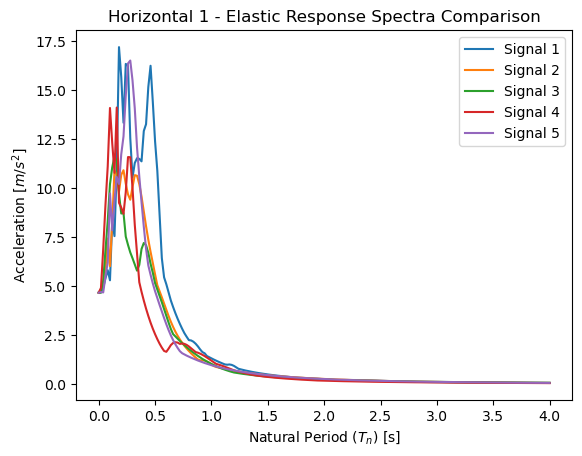

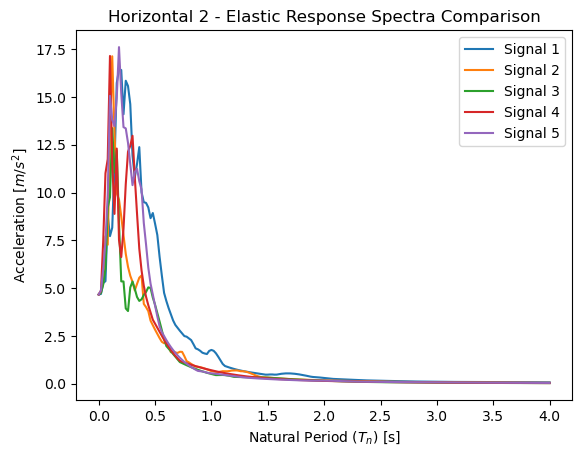

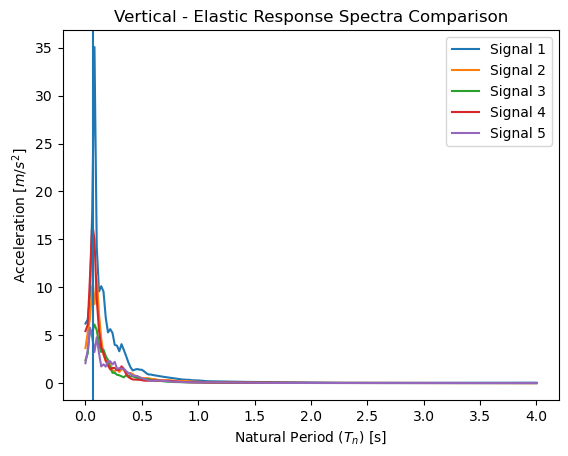

In [ ]:
df_signals = [pd.read_excel(f'Signals/Signal-Set-{i}.xlsx', engine='openpyxl') for i in range(1,6)] 

time_vecs = [i.iloc[:,0] for i in df_signals]      # Time vectors (all equal in principle) - Matrix of dimension 5 (number of signals) x 3440 (number of samples)
acc_hor1_vecs = [i.iloc[:,1] for i in df_signals]  # Horizontal-1 acceleration vectors - Matrix of dimension 5 (number of signals) x 3440 (number of samples)
acc_hor2_vecs = [i.iloc[:,2] for i in df_signals]  # Horizontal-2 acceleration vectors - Matrix of dimension 5 (number of signals) x 3440 (number of samples)
acc_ver_vecs = [i.iloc[:,3] for i in df_signals]   # Vertical acceleration vectors - Matrix of dimension 5 (number of signals) x 3440 (number of samples)

SA_el_hor1_vecs = []
for time, acc in zip(time_vecs,acc_hor1_vecs):
    assert len(time)==len(acc) 
    Dt = time[1]-time[0]
    NPTS = len(time)
    SA_el, _ = ERS.fnc_Elastic_Response_Spectrum(acc, Dt, NPTS, xi)
    SA_el_hor1_vecs.append (SA_el)

SA_el_hor2_vecs = []
for time, acc in zip(time_vecs,acc_hor2_vecs):
    assert len(time)==len(acc) 
    Dt = time[1]-time[0]
    NPTS = len(time)
    SA_el, _ = ERS.fnc_Elastic_Response_Spectrum(acc, Dt, NPTS, xi)
    SA_el_hor2_vecs.append (SA_el)

SA_el_ver_vecs = []
for time, acc in zip(time_vecs,acc_ver_vecs):
    assert len(time)==len(acc) 
    Dt = time[1]-time[0]
    NPTS = len(time)
    SA_el, _ = ERS.fnc_Elastic_Response_Spectrum(acc, Dt, NPTS, xi)
    SA_el_ver_vecs.append (SA_el)

# create period vector
Tn = np.arange(0, 4.02, 0.02)

# Plots 
# Horizontal 1 ERS
for i,SA_el in enumerate(SA_el_hor1_vecs,1):
    plt.plot(Tn, SA_el, label=f"Signal {i}")
plt.title("Horizontal 1 - Elastic Response Spectra Comparison")
plt.xlabel(r"Natural Period ($T_n$) [s]")
plt.ylabel(r"Acceleration [$m/s^2$]")
plt.legend()
plt.show()

# Horizontal 2 ERS
for i,SA_el in enumerate(SA_el_hor2_vecs,1):
    plt.plot(Tn, SA_el, label=f"Signal {i}")
plt.title("Horizontal 2 - Elastic Response Spectra Comparison")
plt.xlabel(r"Natural Period ($T_n$) [s]")
plt.ylabel(r"Acceleration [$m/s^2$]")
plt.legend()
plt.show()

# Vertical ERS
for i,SA_el in enumerate(SA_el_ver_vecs,1):
    plt.plot(Tn, SA_el, label=f"Signal {i}")
plt.title("Vertical - Elastic Response Spectra Comparison")
plt.xlabel(r"Natural Period ($T_n$) [s]")
plt.ylabel(r"Acceleration [$m/s^2$]")
# plt.axvline(0.065,0,1)
plt.legend()
plt.show()



In [4]:
# Check for correct scaling (safetycheck) 

print("\nHorizontal 1:")
for i in range(5):
    print(f"Signal {i+1}: {np.max(np.abs(acc_hor1_vecs[i]))}")

print("\nHorizontal 2:")
for i in range(5):
    print(f"Signal {i+1}: {np.max(np.abs(acc_hor2_vecs[i]))}")

print("\nVertical:")
for i in range(5):
    print(f"Signal {i+1}: {np.max(np.abs(acc_ver_vecs[i]))}")
# Memo: The vertical direction is scaled with the same factor as the "first principal horizontal direction"


Horizontal 1:
Signal 1: 4.66956
Signal 2: 4.66956
Signal 3: 4.669560000000001
Signal 4: 4.66956
Signal 5: 4.66956

Horizontal 2:
Signal 1: 4.66956
Signal 2: 4.66956
Signal 3: 4.669560000000001
Signal 4: 4.669560000000001
Signal 5: 4.669560000000001

Vertical:
Signal 1: 6.219005124426918
Signal 2: 3.66223794974537
Signal 3: 2.406385836522875
Signal 4: 5.430044066354665
Signal 5: 2.0849876926035


# Question 1b:



In [5]:
# EN1998-1 Spectra 

eta = np.sqrt(10/(5+xi))
print(f"Eta {eta:.2f}") #Add eta check
T = np.linspace(0,4,1000)

# Parameters corresponding to Ground Type D for Horizontal Spectrum
S = 1.8
TB = 0.10
TC = 0.30
TD = 1.2

def horizontal_elastic_acc_spectrum(T, eta):
 Se_T_values = []
 for T in T:
   if 0 <= T <= TB:
      Se_T = a_g_ref * S * (1 + (T / TB) * (eta * 2.5 - 1))
      Se_T_values.append(Se_T)
   elif TB < T <= TC:
      Se_T = a_g_ref * S * eta * 2.5
      Se_T_values.append(Se_T)
   elif TC < T <= TD:
      Se_T = a_g_ref * S * eta * 2.5 * (TC / T)
      Se_T_values.append(Se_T)
   elif TD < T <= 4.0:
      Se_T = a_g_ref * S * eta * 2.5 * (TC * TD) / (T ** 2)
      Se_T_values.append(Se_T)
   else:
      Se_T = 0 
      Se_T_values.append(Se_T)
 return Se_T_values

# Parameters corresponding to Ground Type D for Vertical Spectrum
TB = 0.05 
TC = 0.15
TD = 1.0

def vertical_elastic_acceleration_response_spectrum(T, eta):
  Svd_T_values = []
  for T in T: 
      if 0 <= T <= TB:
         Svd_T = a_vg_ref * (1 + (T / TB) * (eta * 3.0 - 1))
         Svd_T_values.append(Svd_T)
      elif TB < T <= TC:
         Svd_T = a_vg_ref * eta * 3.0
         Svd_T_values.append(Svd_T)
      elif TC < T <= TD:
         Svd_T = a_vg_ref * eta * 3.0 * (TC / T)
         Svd_T_values.append(Svd_T)
      elif TD < T:
         Svd_T = a_vg_ref * eta * 3.0 * (TC * TD) / (T ** 2)
         Svd_T_values.append(Svd_T)
      else:
         Svd_T = 0  
         Svd_T_values.append(Svd_T)
  return Svd_T_values


Eta 1.41


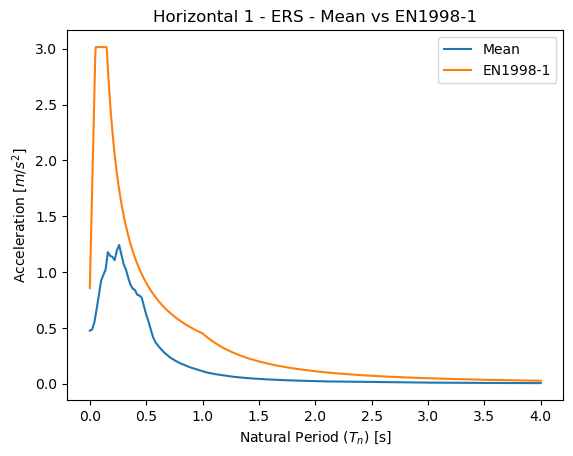

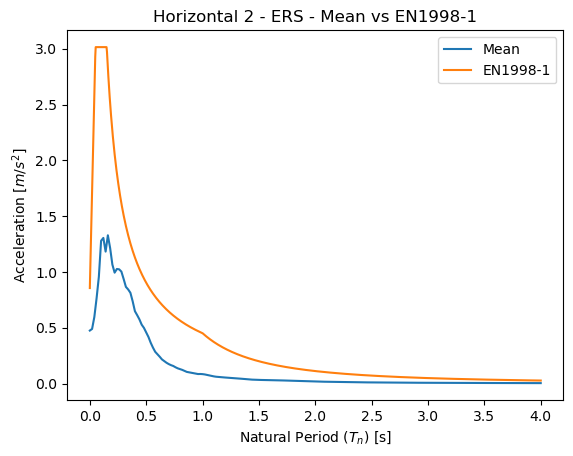

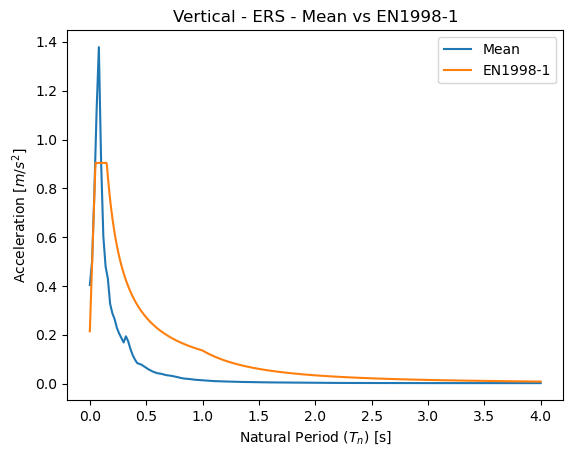

In [6]:
df_SA_el_hor_1_mean = pd.read_excel('ERS_Means/SA_el_hor1_mean.xlsx', engine='openpyxl')
df_SA_el_hor_2_mean = pd.read_excel('ERS_Means/SA_el_hor2_mean.xlsx', engine='openpyxl')
df_SA_el_ver_mean = pd.read_excel('ERS_Means/SA_el_ver_mean.xlsx', engine='openpyxl')

# Mean accelerations are stored in [m/s^2] in the xlsx files. 

plt.plot(df_SA_el_hor_1_mean.iloc[:,0],df_SA_el_hor_1_mean.iloc[:,2]/9.81, label='Mean')
plt.plot(T,horizontal_elastic_acc_spectrum(T,eta), label='EN1998-1')
plt.title("Horizontal 1 - ERS - Mean vs EN1998-1")
plt.xlabel(r"Natural Period ($T_n$) [s]")
plt.ylabel(r"Acceleration [$m/s^2$]")
plt.legend()
plt.show()

plt.plot(df_SA_el_hor_2_mean.iloc[:,0],df_SA_el_hor_2_mean.iloc[:,2]/9.81, label='Mean')
plt.plot(T,horizontal_elastic_acc_spectrum(T,eta), label='EN1998-1')
plt.title("Horizontal 2 - ERS - Mean vs EN1998-1")
plt.xlabel(r"Natural Period ($T_n$) [s]")
plt.ylabel(r"Acceleration [$m/s^2$]")
plt.legend()
plt.show()

plt.plot(df_SA_el_ver_mean.iloc[:,0],df_SA_el_ver_mean.iloc[:,2]/9.81, label='Mean')
plt.plot(T,vertical_elastic_acceleration_response_spectrum(T,eta), label='EN1998-1')
plt.title("Vertical - ERS - Mean vs EN1998-1")
plt.xlabel(r"Natural Period ($T_n$) [s]")
plt.ylabel(r"Acceleration [$m/s^2$]")
plt.legend()
plt.show()

The first difference between the Mean Spectra and the EN1998-1 Spectra is conceptual: the former is the result of a limited amount of seismic recordings, while the latter is an empirical curve derived from probabilistic seismic hazard analysis. As such, the first may be more accurate in describing the seismic behavior of a specific region (assuming all signals are part of a somewhat coherent dataset) while the second provides a safe estimate of excitations based on a limited amount of assumptions (i.e. surface-wave magnitude and a gross ground characterization).\
It is apparent how the Mean Spectra show different behavior for each principal direction (since it is based on observations), whereas EN1998-1 prescribes the use of the same curve for both horizontal principal directions.
As it should be expected, the code version of the ERS returns higher horizontal excitations compared to the ones derived from the recorded signals.
Since the signals hereby examined concern the seismic activity in Groningen (from script documentation), it is not surprising to notice the Mean Spectrum exceed the EN1998-1 Spectrum in the last plot. The vertical acceleration component is in fact frequently dominant in human-induced Earthquakes, whereas it is usually secondary in natural Earthquakes. The curve given by EN1998-1 is therefore not calibrated to capture these specific anthropic phenomena. 

# Extra Plots for other sections of report


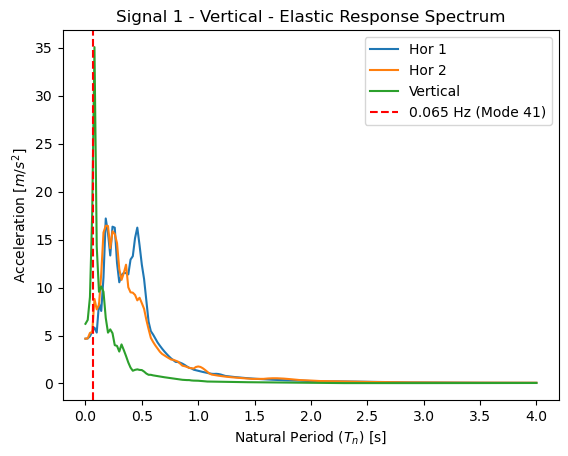

In [10]:
# Plot to demonstrate extreme deformations for mode 41 of the structure

# Vertical ERS
plt.plot(Tn, SA_el_hor1_vecs[0], label=f"Hor 1")
plt.plot(Tn, SA_el_hor2_vecs[0], label=f"Hor 2")
plt.plot(Tn, SA_el_ver_vecs[0], label=f"Vertical")
plt.title("Signal 1 - Vertical - Elastic Response Spectrum")
plt.xlabel(r"Natural Period ($T_n$) [s]")
plt.ylabel(r"Acceleration [$m/s^2$]")
plt.axvline(0.065,0,1, color='r', label='0.065 Hz (Mode 41)', ls="--")
plt.legend()
plt.show()